# Feature Analysis Pipeline (Inline Notebook)
This notebook replicates the original `Feature_analysis.py` in a ipynb format for better interpretability.

In [2]:
# 1. Setup: imports and parameters
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# --- User parameters ---
input_matrix = '../data/input/consensus_filt_annot_dar.tsv' # Path to input differential peaks calling matrix
exclude_features = ['tss_1kb']   # List of feature names to exclude, e.g. ['feature1', 'feature2']
output_dir = '../data/output/'  # Output directory
fc_column = 'logFC'  # Fold-change column name
diff_peaks_column = 'BAFdep'  # Differential peaks column name
permutation = True  # Set True to compute permutation importances
threads = 8  # Number of parallel threads

p_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Create output directories
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, 'overlap_beds'), exist_ok=True)


## 2. Build Feature Matrix
Overlap ATAC-seq peaks with feature BED files and create binary matrix.

In [3]:
# Define BED files list
bed_path = '../data/bed/'
bed_list = [os.path.join(bed_path, f) for f in os.listdir(bed_path)
            if f.endswith('.bed') or f.endswith('.bed.gz')]

# Read input matrix and prepare BED for overlap
matrix_df = pd.read_csv(input_matrix, sep='\t')
bed_out = matrix_df.iloc[:, :3].copy()
bed_out['name'] = ['Peak_' + str(i) for i in range(len(bed_out))]
bed_out[fc_column] = matrix_df[fc_column]
bed_out[diff_peaks_column] = matrix_df[diff_peaks_column]
bed_file = os.path.join(output_dir, 'final_merged_peaks.bed')
bed_out.to_csv(bed_file, sep='\t', header=False, index=False)

# Perform bedtools intersect
for bed in bed_list:
    name = os.path.basename(bed).split('.')[0]
    out = os.path.join(output_dir, 'overlap_beds', f'{name}_overlap.bed')
    os.system(f"bedtools intersect -a {bed_file} -b {bed} -wa -wb > {out}")

# Build binary feature matrix
features = [os.path.basename(b).split('.')[0] for b in bed_list]
feat_df = pd.DataFrame({
    'peak_name': bed_out['name'],
    fc_column: bed_out[fc_column],
    diff_peaks_column: bed_out[diff_peaks_column]
}).set_index('peak_name')

# Initialize feature matrix with base columns
base_df = feat_df.copy()

# Accumulate feature columns in a dict
feature_cols = {}

for feat in features:
    col = pd.Series(0, index=base_df.index, name=feat)
    overlap_file = os.path.join(output_dir, 'overlap_beds', f'{feat}_overlap.bed')
    if os.path.exists(overlap_file) and os.path.getsize(overlap_file) > 0:
        ov = pd.read_csv(overlap_file, sep='\t', header=None)
        peaks = ov[3].unique()
        col.loc[col.index.isin(peaks)] = 1
    feature_cols[feat] = col

# Concatenate all columns at once to avoid fragmentation
feat_df = pd.concat([base_df] + list(feature_cols.values()), axis=1)

# Save feature matrix
feat_df.fillna(0, inplace=True)
feat_df.to_csv(os.path.join(output_dir, 'feature_matrix.csv'))
feat_df


,logFC,BAFdep,FOS,NFIC,IKZF2,STAT5A,PML,TBP,H3K4me2,PAX8,...,ARID3A,ESRRA,KLF5,STAT3,CBX5,CREB1,NR2F1,BCL3,IKZF1,EP300
peak_name,,,,,,,,,,,,,,,,,,,,,
Peak_0,-0.090458,False,0,0,0,0,1,0,1,0,...,1,0,1,0,0,1,0,0,0,0
Peak_1,-1.212419,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Peak_2,-0.013899,False,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
Peak_3,-0.360555,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Peak_4,-0.377758,False,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Peak_112399,-3.253650,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Peak_112400,0.111165,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Peak_112401,-0.899040,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Exclude Specified Features (Optional)
if feature exclusion is specified, samples with feature binding will be removed

In [4]:
# Remove peaks with excluded features
if exclude_features:
    for feat in exclude_features:
        if feat in feat_df.columns:
            feat_df = feat_df[feat_df[feat] != 1]
    # Drop excluded feature columns
    feat_df = feat_df.drop(columns=exclude_features, errors='ignore')
    feat_df.reset_index(drop=True, inplace=True)


## 4. Random Forest Training and Evaluation
Hyperparameter tuning, calculated ROC/PR curves, and saves results.

Best params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50} Val Accuracy: 0.8261346054667354
Test Accuracy: 0.8232450203055501


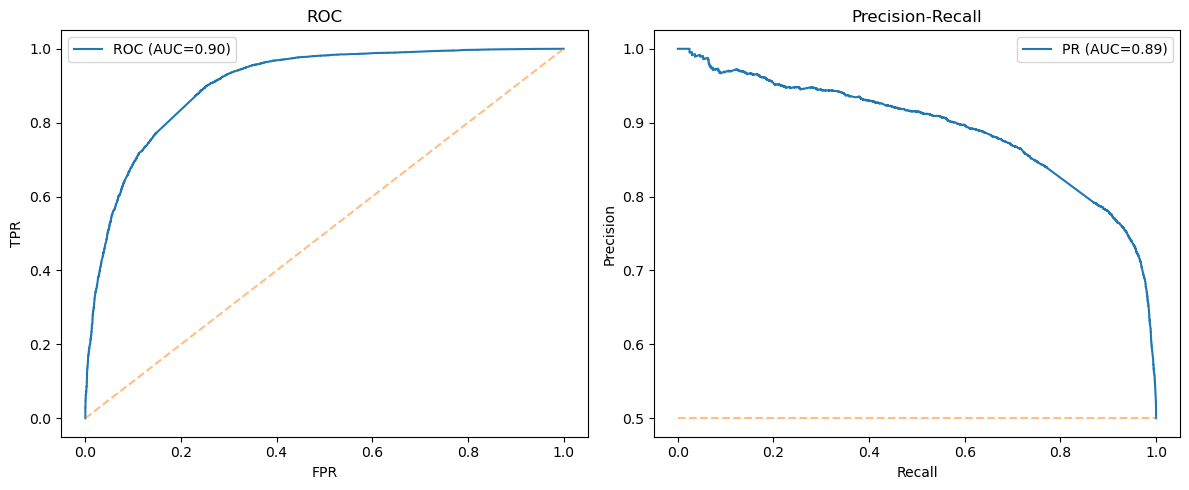

In [5]:
# Prepare dat
feat_df_rf = feat_df.copy()
if fc_column in feat_df_rf.columns:
    feat_df_rf = feat_df_rf.drop(columns=[fc_column])

# Undersample the dataset to balance classes
if diff_peaks_column in feat_df_rf.columns:
    pos_samples = feat_df_rf[feat_df_rf[diff_peaks_column] == 1]
    neg_samples = feat_df_rf[feat_df_rf[diff_peaks_column] == 0]
    
    if len(pos_samples) > len(neg_samples):
        pos_samples = pos_samples.sample(len(neg_samples), random_state=3)
    else:
        neg_samples = neg_samples.sample(len(pos_samples), random_state=3)
    
    feat_df_rf = pd.concat([pos_samples, neg_samples]).reset_index(drop=True)

X = feat_df_rf.drop(columns=[diff_peaks_column])
y = feat_df_rf[diff_peaks_column]

# Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=3, stratify=y_temp)

# Hyperparameter tuning
param_grid = p_grid
best_score = 0
best_params = None
for params in ParameterGrid(param_grid):
    clf = RandomForestClassifier(**params, random_state=3, n_jobs=threads)
    clf.fit(X_train, y_train)
    score = clf.score(X_val, y_val)
    if score > best_score:
        best_score = score
        best_params = params
print('Best params:', best_params, 'Val Accuracy:', best_score)

# Final training
clf_final = RandomForestClassifier(**best_params, random_state=3, n_jobs=threads)
clf_final.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Evaluation
y_pred = clf_final.predict(X_test)
print('Test Accuracy:', accuracy_score(y_test, y_pred))

# ROC & PR curves
fpr, tpr, _ = roc_curve(y_test, clf_final.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
prec, rec, _ = precision_recall_curve(y_test, clf_final.predict_proba(X_test)[:,1])
pr_auc = auc(rec, prec)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'--',alpha=0.5)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC')
plt.legend()
plt.subplot(1,2,2)
plt.plot(rec, prec, label=f'PR (AUC={pr_auc:.2f})')
plt.plot([0,1],[0.5,0.5],'--',alpha=0.5)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'roc_pr_curves.pdf'))


## 5. Feature Importances
Compute MDI and optional permutation importances.

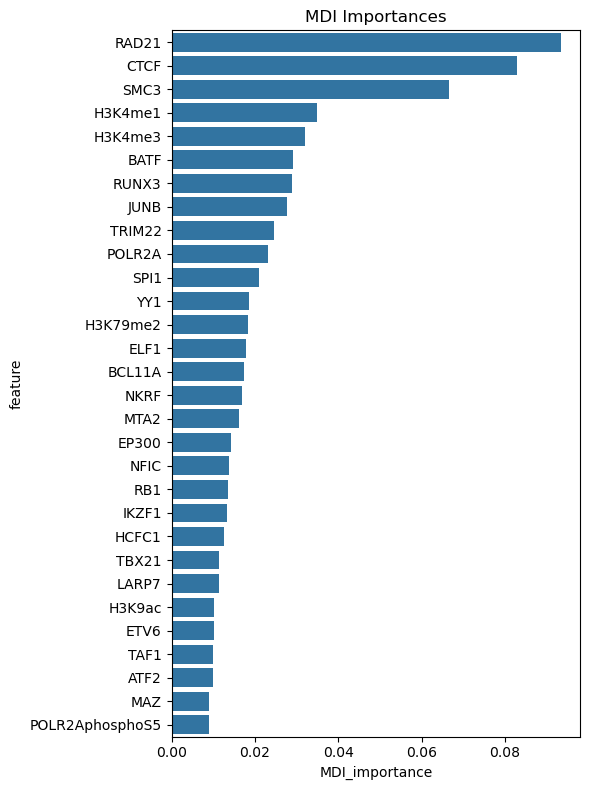

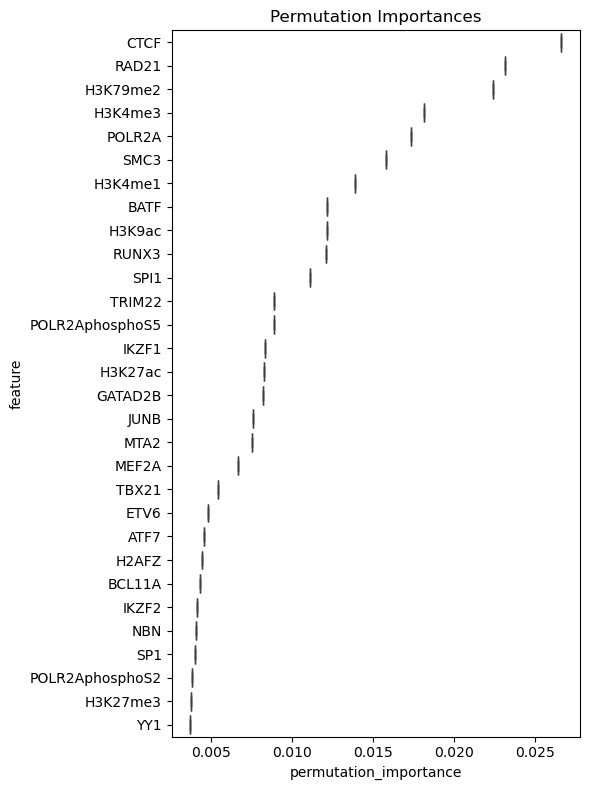

In [6]:
# MDI importances
mdi = clf_final.feature_importances_
fi_df = pd.DataFrame({'feature': clf_final.feature_names_in_, 'MDI_importance': mdi})
fi_df = fi_df.sort_values('MDI_importance', ascending=False)

# Plot top 30
top30 = fi_df.head(30)
plt.figure(figsize=(6,8))
sns.barplot(x='MDI_importance', y='feature', data=top30)
plt.title('MDI Importances')
plt.tight_layout()
plt.show()

# Permutation importances
if permutation:
    perm = permutation_importance(clf_final, X_val, y_val, n_repeats=5, random_state=3, n_jobs=threads)
    perm_df = pd.DataFrame({
        'feature': clf_final.feature_names_in_,
        'permutation_importance': perm.importances_mean,
        'std': perm.importances_std
    }).sort_values('permutation_importance', ascending=False)
    top_perm = perm_df.head(30)
    plt.figure(figsize=(6,8))
    sns.boxplot(x='permutation_importance', y='feature', data=top_perm)
    plt.title('Permutation Importances')
    plt.tight_layout()
    plt.show()
    # merge with fi_df
    fi_df = fi_df.merge(perm_df[['feature','permutation_importance','std']], on='feature')

# Save importances
fi_df.to_csv(os.path.join(output_dir, 'feature_importance.csv'), index=False)


## 6. Ridge Regression Importances and Correlation
Subsampled Ridge regression and correlation with MDI.

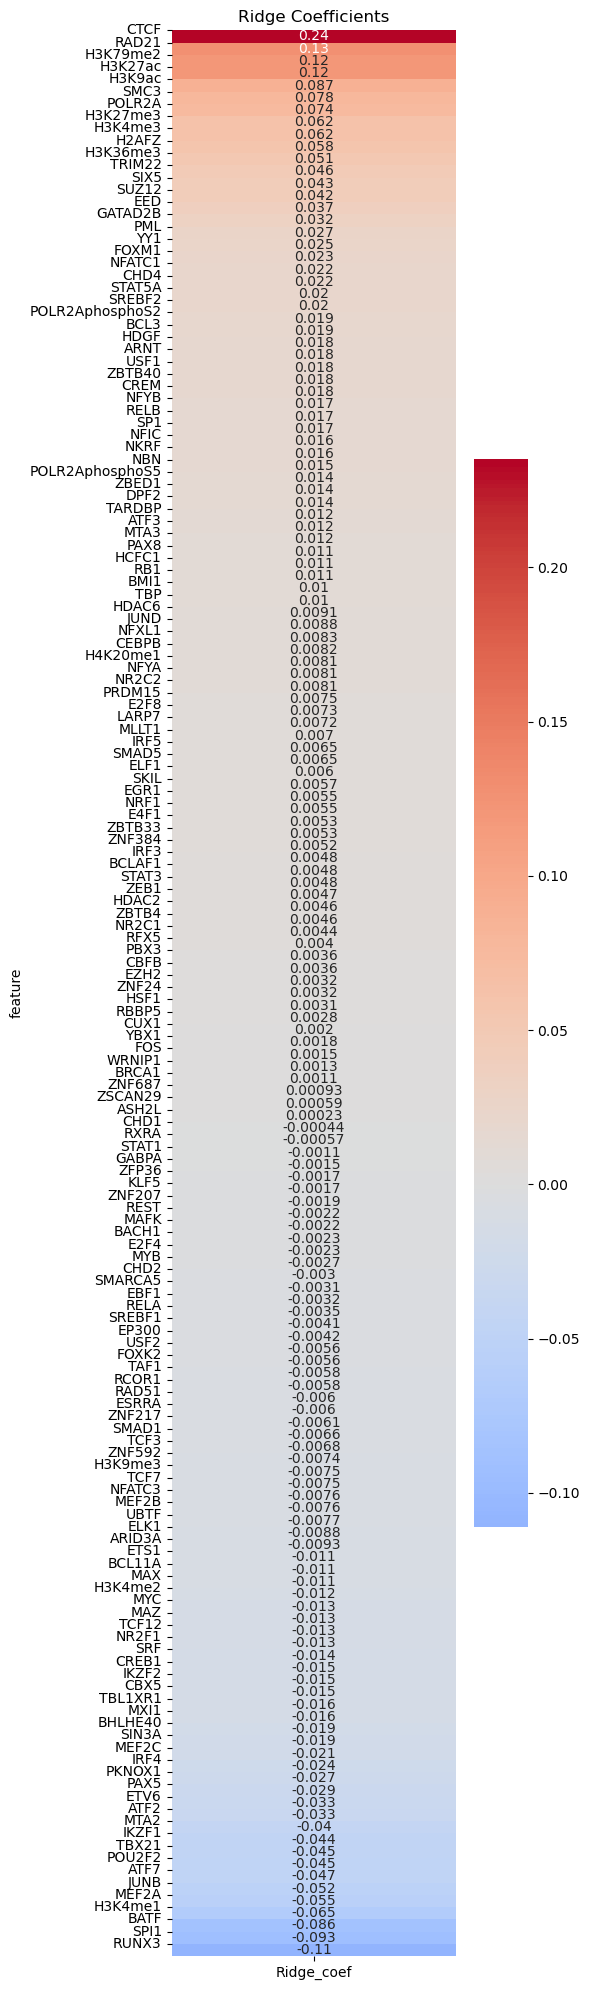

In [7]:
# Prepare data for Ridge
ridge_df = feat_df.copy()
if diff_peaks_column in ridge_df.columns:
    ridge_df = ridge_df.drop(columns=[diff_peaks_column])
ridge_df = ridge_df.replace([np.inf, -np.inf], np.nan).dropna()

X_r = ridge_df.drop(columns=[fc_column])
y_r = ridge_df[fc_column]
scale = StandardScaler()
X_s = scale.fit_transform(X_r)

# Subsample and fit
coefs = {col: [] for col in X_r.columns}
for i in range(10):
    idx = ridge_df.sample(frac=0.7, random_state=42+i).index
    pos = ridge_df.index.get_indexer(idx)
    model = Ridge(alpha=1.0)
    model.fit(X_s[pos], y_r.iloc[pos])
    for j, col in enumerate(X_r.columns):
        coefs[col].append(model.coef_[j])

# Aggregate
mean_coefs = {f: np.mean(vals) for f, vals in coefs.items()}
std_coefs = {f: np.std(vals) for f, vals in coefs.items()}
ridge_imp = pd.DataFrame([
    {'feature': f, 'Ridge_coef': mean_coefs[f], 'Ridge_std': std_coefs[f]}
    for f in X_r.columns
])

# Sort by coefficients
ridge_imp = ridge_imp.sort_values('Ridge_coef', ascending=False)

# Plot heatmap
plt.figure(figsize=(6,20))
sns.heatmap(
    ridge_imp.set_index('feature')[['Ridge_coef']],
    annot=True, cmap='coolwarm', center=0
)
plt.yticks(
    ticks=range(len(ridge_imp)),
    labels=ridge_imp['feature'],
    rotation=0
)
plt.title('Ridge Coefficients')
plt.tight_layout()
plt.show()


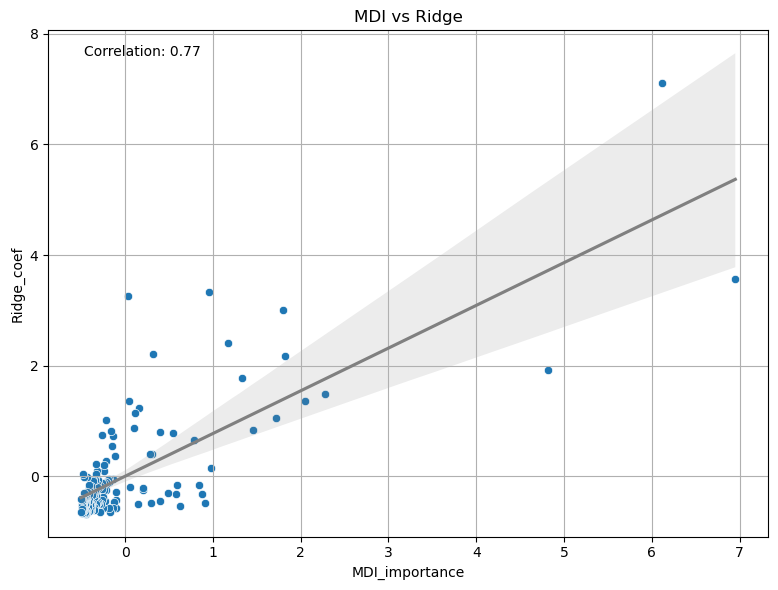

Exception ignored in: <function ResourceTracker.__del__ at 0x7f1d97f91440>
Traceback (most recent call last):
  File "/mnt/disk/home/akang/.conda/envs/manuscript/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/mnt/disk/home/akang/.conda/envs/manuscript/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/mnt/disk/home/akang/.conda/envs/manuscript/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fe477985440>
Traceback (most recent call last):
  File "/mnt/disk/home/akang/.conda/envs/manuscript/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/mnt/disk/home/akang/.conda/envs/manuscript/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/mnt/disk/home/akang/.conda/envs/manuscript/lib/python3.12/multiprocessing/resource_tracker.py",

In [8]:
# Correlation between MDI and Ridge
merged = fi_df.merge(ridge_imp[['feature','Ridge_coef']], on='feature')

merged['Ridge_coef'] = merged['Ridge_coef'].abs()  # Use absolute values for correlation

# Standard scale to scale across samples and fit to normal distribution
scaler = StandardScaler( 
    with_mean=True, with_std=True
)
merged['MDI_importance'] = scaler.fit_transform(merged[['MDI_importance']])
merged['Ridge_coef'] = scaler.fit_transform(merged[['Ridge_coef']])

plt.figure(figsize=(8,6))
sns.scatterplot(x='MDI_importance', y=merged['Ridge_coef'], data=merged)
corr = merged['MDI_importance'].corr(merged['Ridge_coef'], method='pearson') # Pearson correlation best for linear relationships w/ normal distribution
plt.text(0.05,0.95,f'Correlation: {corr:.2f}', transform=plt.gca().transAxes)
plt.xlabel('MDI Importance'); plt.ylabel('|Ridge_coef|')
plt.title('MDI vs Ridge')
plt.grid(True)
plt.tight_layout()
# Fit a line
sns.regplot(x='MDI_importance', y=merged['Ridge_coef'], data=merged, scatter=False, color='grey')
plt.show()